In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import torch
import shap
import pickle as pkl
from typing import List

import matplotlib.gridspec as gridspec
from dataset import Dataset
from sklearn.impute import SimpleImputer
from sklearn import preprocessing, model_selection
from sklearn import metrics
from captum.attr import (
    DeepLift,
    FeatureAblation,
    FeaturePermutation,
    IntegratedGradients,
    KernelShap,
    Lime,
    ShapleyValueSampling,
    GradientShap,
)
module_path = os.path.abspath(os.path.join('CATENets/'))
if module_path not in sys.path:
    sys.path.append(module_path)

import catenets.models.torch.pseudo_outcome_nets as pseudo_outcome_nets

/homes/gws/mingyulu/miniconda3/envs/torch_gpu/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def plot_feature_values(feature_values, x_test, names):

    feature_num = feature_values.shape[1]
    ind = np.argpartition(np.abs(feature_values).mean(0).round(4), -feature_num)[-feature_num:]
    
    feature_names = [
        a + ": " + str(b) for a,b in zip(names[ind], np.abs(feature_values[:, ind]).mean(0).round(4))
    ]

    shap.summary_plot(
        feature_values[:, ind],
        x_test[:, ind], 
        feature_names=feature_names,
        show=False
    )
    
    
    fig, ax = plt.gcf(), plt.gca()
    plt.gcf().axes[-1].set_aspect(100)
    # plt.gcf().axes[-1].set_box_aspect(100)
    
    # Modifying main plot parameters
    ax.tick_params(labelsize=12)
    
    ax.set_xlabel("", fontsize=8)
    ax.set_title('SPRINT - Shapley Value', fontsize=14)
    
    # Add custom text to the x-axis
    ax.text(-0.1, -2.5, "Standard treatment better", color="black", ha="center", fontsize=15)  # replace 0.2 and -1 with your preferred coordinates
    ax.text(0.1, -2.5, "Intensive treatment better", color="black", ha="center", fontsize=15)  # replace 0.8 and -1 with your preferred coordinates

    # Get colorbar
    cb_ax = fig.axes[1] 
    
    # Modifying color bar parameters
    cb_ax.tick_params(labelsize=10)
    cb_ax.set_ylabel("Feature value", fontsize=15)

    plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Data
data = [
    ["", 0.75, 0.64, 0.89,"All Patients (1.1.2)"],

    ["No", 1.20, 0.87,1.65, "Antiplatelet in prev 48h"],
    ["Yes",1.02, 0.73,1.43, "Antiplatelet in prev 48h"],

    ['> 9', 1.03, 0.67, 1.60,"Glucose (mmol/L)"],
     ['6-8', 1.16, 0.82, 1.66,"Glucose (mmol/L)"],
     ['<=5', 1.23, 0.72, 2.12,"Glucose (mmol/L)"],

     ['>90', 0.97, 0.64, 1.46,"DBP (mm Hg)"],
     ['75-89', 1.08, 0.73, 1.58,"DBP (mm Hg)"],
      ['< 74', 1.32, 0.86, 2.01,"DBP (mm Hg)"],

      ['> 165', 1.11, 0.74, 1.65,"SBP (mm Hg)"],
     ['144- 165', 1.09, 0.74, 1.62,"SBP (mm Hg)"],
     ['<= 143', 1.18, 0.78, 1.78,"SBP (mm Hg)"],
    
      ['LACI', 0.91, 0.48, 1.72,"Stroke syndrome"],
      ['POCI', 1.04, 0.49, 2.22,"Stroke syndrome"],
      ['PACI', 1.07, 0.76, 1.51,"Stroke syndrome"],
      ['TACI', 1.36, 0.89, 2.08,"Stroke syndrome"],
    
     ['No', 1.09, 0.83, 1.43,"atrial fibrillation"],
     ['Yes', 1.20, 0.76, 1.90,"atrial fibrillation"],

     ['Female', 1.04, 0.75, 1.59,"Sex"],
     ['Male',1.21, 0.86, 1.69, "Sex"],

     ['0-5', 0.85, 0.52, 1.38, 'NIHSS score'],
     ['6-14', 1.08, 0.81, 1.45, 'NIHSS score'],
     ['15-24',1.73, 0.94, 3.20, 'NIHSS score'],
     # ['>25',7.43, 0.43, 12.9, 'NIHSS score'],
    
     # ['>= 25',7.43, 0.43, 12.9, 'NIHSS'],
    
     ["< 80",0.70, 0.56, 0.87 , "Previous CKD (No)"],
     ["> 80", 0.82, 0.63, 1.07 , "Previous CKD (Yes)"]
]

labels, medians, mins, maxs, categories = zip(*data)

# Compute the errors

lower_err = [median - min_ for median, min_ in zip(medians, mins)]
upper_err = [max_ - median for max_, median in zip(maxs, medians)]
errors = [lower_err, upper_err]

fig, ax = plt.subplots(figsize=(10,10))

# Plotting
y_range = range(len(labels))

# Reversing order
y_range = y_range[::-1]
medians = medians[::-1]
errors = [errors[0][::-1], errors[1][::-1]]

plt.errorbar(medians, y_range, xerr=errors, fmt='s', color="black", markersize=10)

# Set labels with category after range
new_labels = []
last_category = None
for label, min_, max_, category in reversed(list(zip(labels, mins, maxs, categories))):
    if category != last_category:
        new_labels.append(f'{category} - {label} ')
        last_category = category
    else:
        new_labels.append(f'{label}')

ax.set_yticks(y_range)
ax.set_yticklabels(new_labels, fontsize=12) # Larger font size here

ax.tick_params(axis='x', labelsize=12) # Larger font size for x-axis ticks

# Add custom text to the x-axis
ax.text(0.4, -3.2, "rt-TPA worse", color="black", ha="center", fontsize=16) # Larger font size here
ax.text(2.0, -3.2, "rt-TPA better", color="black", ha="center", fontsize=16) # Larger font size here

# Add a vertical dashed line at x = 0.91
ax.axvline(0.91, color='black', linestyle='--')
ax.set_xlim(0, 3)


plt.title("IST-3: Adjusted Odds Ratio by Subgroup", size=14)
plt.tight_layout()
plt.show()

In [3]:
adj_p = {
    "age":0.32, 
    "sbp":0.77,
    "female":0.45 ,
    "race_black":0.83,
    "sub_cvd":0.39,
    "sub_ckd": 0.36
}
          
            # "smoke_3cat",
            # "aspirin",
            # "statin",

In [4]:
data = Dataset("sprint", 0)

data.get_feature_names()

Index(['age', 'sbp', 'dbp', 'n_agents', 'egfr', 'screat', 'chr', 'glur', 'hdl',
       'trr', 'umalcr', 'bmi', 'female', 'race_black', 'smoke_3cat', 'aspirin',
       'statin', 'sub_cvd', 'sub_ckd'],
      dtype='object')

In [303]:
x, w, y = data.get_data()

model = pseudo_outcome_nets.XLearner(  
    x.shape[1],
    binary_y=(len(np.unique(y)) == 2),
    n_layers_out=2,
    n_units_out=100,
    batch_size=128,
    n_iter=1000,
    nonlin="relu",
    device="cpu",
    # seed= i
)

# model.fit(x, y, w)

In [248]:
import pickle as pkl

predict_results = pkl.load(open("results/sprint/predict_results_True.pkl",'rb'))

np.mean(predict_results) , np.std(predict_results)/np.sqrt(predict_results.shape[0])

label_umap = predict_results.mean(0) > np.mean(predict_results)

In [8]:
data = Dataset("sprint", 0)

x, _, _ = data.get_data()

0.015827851205368695 (200, 9361)
Output 0.015827851205368695: 95% CI = (0.008, 0.024)


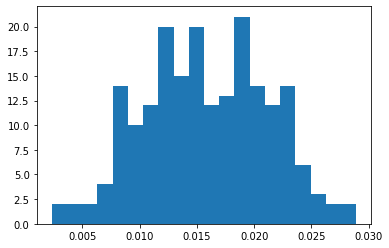

In [249]:
import pickle as pkl

predict_results  = pkl.load(open("results/sprint/predict_results_True.pkl", 'rb'))

mean_ates = predict_results.mean(1)

print(mean_ates.mean(0), predict_results.shape)
plt.hist(mean_ates, bins=20)

lower_bounds = np.percentile(mean_ates, 5, axis=0)
upper_bounds = np.percentile(mean_ates, 95, axis=0)

# Print the confidence intervals
print(f"Output {mean_ates.mean(0)}: 95% CI = ({lower_bounds:.3f}, {upper_bounds:.3f})")

(200, 9361, 19)


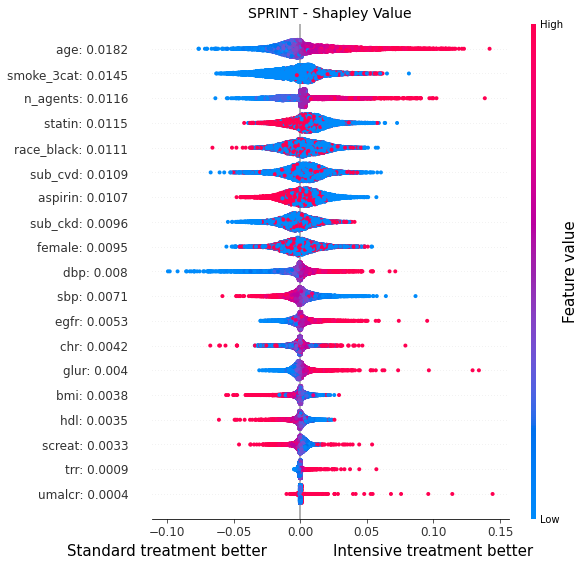

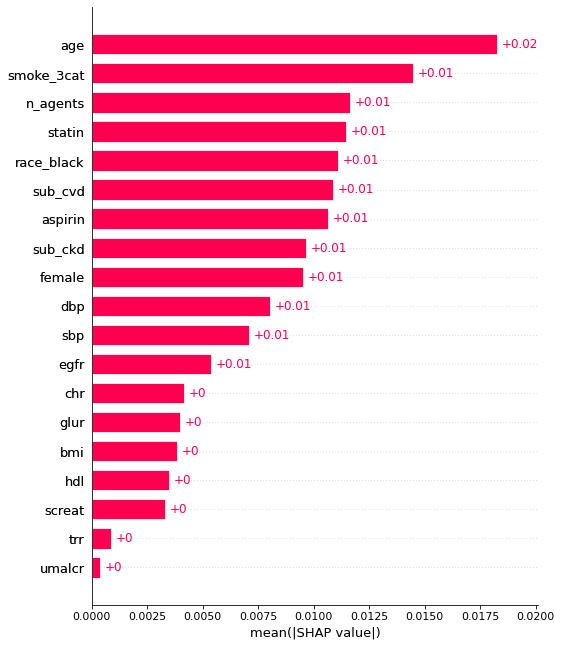

In [9]:
gender_index = data.get_feature_names().tolist().index('female')

avg_shap = pkl.load(open("results/sprint/shap_bootstrapped_True.pkl",'rb'))

print(avg_shap.shape)

plot_feature_values(
    avg_shap.mean(0),
    x, 
    data.get_feature_names()
)

exp = shap.Explanation(
    avg_shap.mean(0),  
    feature_names = data.get_feature_names()
)

shap.plots.bar(
    exp,
    max_display=len(data.get_feature_names()),
)


In [17]:
from scipy import stats

shap_imp = {}

for k, _ in adj_p.items():
    feature_index = data.get_feature_names().tolist().index(k)
    shap_imp[k] = np.abs(avg_shap.mean(0)[feature_index]).mean()
        
res = stats.spearmanr(np.array(list(adj_p.values())), np.array(list(shap_imp.values())))
res.statistic, res.pvalue

(-0.6, 0.20799999999999982)

[6 2 3 1 4 5] [6 5 3 1 2 4]


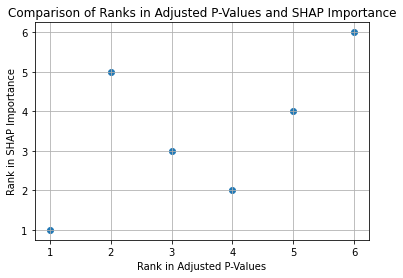

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Convert dictionary values to numpy arrays for easier manipulation
adj_p_values = -1*np.array(list(adj_p.values()))
shap_imp_values = np.array(list(shap_imp.values()))

# Calculate ranks. The '+1' makes the ranks start from 1 instead of 0.
adj_p_ranks = np.argsort(np.argsort(adj_p_values)) + 1
shap_imp_ranks = np.argsort(np.argsort(shap_imp_values)) + 1


print(adj_p_ranks, shap_imp_ranks)
# Plotting the ranks against each other
plt.scatter(adj_p_ranks, shap_imp_ranks)


plt.xlabel('Rank in Adjusted P-Values')
plt.ylabel('Rank in SHAP Importance')
plt.title('Comparison of Ranks in Adjusted P-Values and SHAP Importance')
plt.grid(True)
plt.show()

Text(0.5, 0, 'Number of Models in Ensemble')

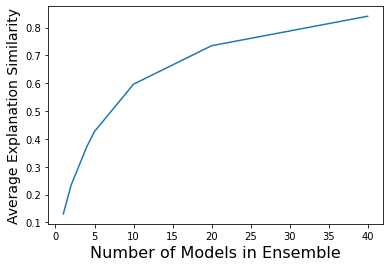

In [247]:
from sklearn.metrics.pairwise import cosine_similarity

def get_trial_pairs_and_cosine_values(cosine_sim, prefix=''):
    trial_pairs = []
    cosine_values = []
    for i in range(cosine_sim.shape[0]):
        for j in range(cosine_sim.shape[1]):
            if i < j:
                trial_pairs.append(f"{prefix}{i}-{j}")
                cosine_values.append(cosine_sim[i, j])
    return trial_pairs, cosine_values

np.random.shuffle(avg_shap)
t, n, d = avg_shap.shape

# Compute cosine similarities

results = []
ensemble_model_num = [1, 2, 4, 5, 10, 20, 40]

for i in  ensemble_model_num:

    ensemble_shap = avg_shap.reshape(-1, i, n, d).mean(axis=1)

    cosine_sim_ensemble = cosine_similarity(ensemble_shap.reshape(ensemble_shap.shape[0], -1))

    trial_pairs_ensemble, cosine_values_ensemble = get_trial_pairs_and_cosine_values(cosine_sim_ensemble, 'E')
    results.append(np.mean(cosine_values_ensemble))
    
plt.plot(ensemble_model_num, results)

plt.ylabel("Average Explanation Similarity", size=14)
plt.xlabel("Number of Models in Ensemble", size=16)

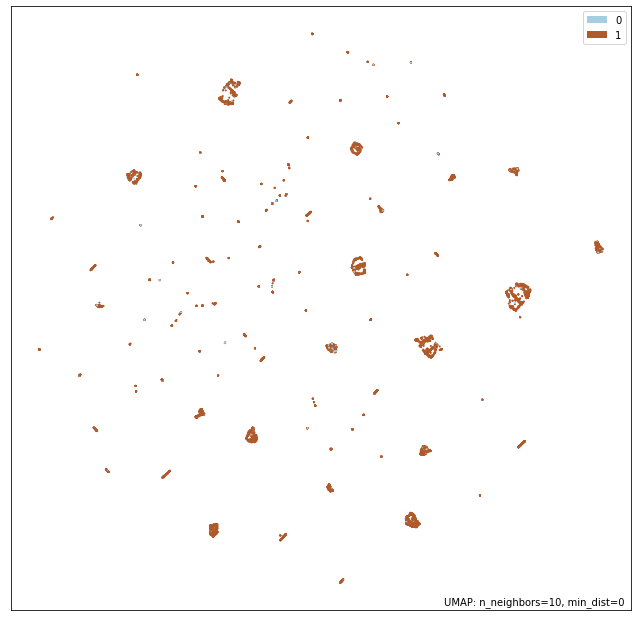

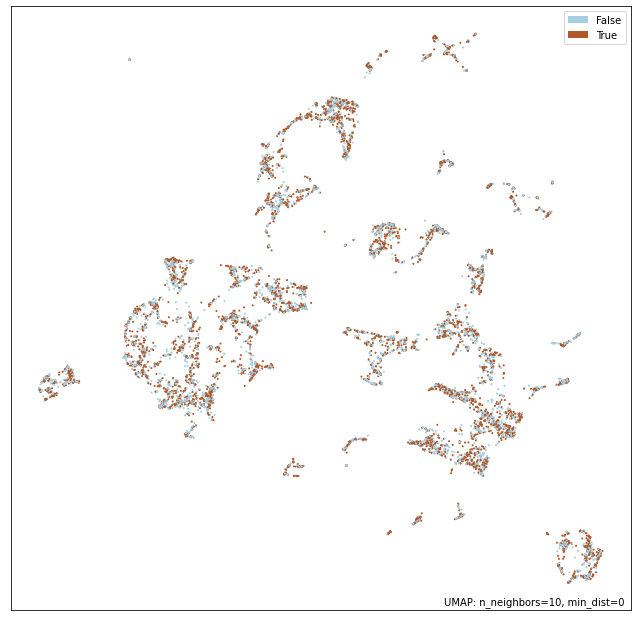

In [243]:
from umap import UMAP
import umap.plot

reducer = umap.UMAP(n_components=2, n_neighbors=10, min_dist=0)
X_2d = reducer.fit(x)

# Plot the results
umap.plot.points(X_2d, labels=y,color_key_cmap='Paired')

# # compute 2D embedding of SHAP values
s_2d = UMAP(
  n_components=2, n_neighbors=10, min_dist=0
).fit(avg_shap.mean(0))

umap.plot.points(s_2d, labels=label_umap,color_key_cmap='Paired')

In [308]:
import numpy as np
from scipy.stats import spearmanr


avg_shap_sprint = pkl.load(open("results/sprint/shap_bootstrapped_True.pkl",'rb'))
avg_shap_accord = pkl.load(open("results/accord/shap_bootstrapped_True.pkl",'rb'))

_ , n_sprint, d_sprint = avg_shap_sprint.shape
_ , n_accord, d_accord = avg_shap_accord.shape

accord = Dataset("accord", 0)
sprint = Dataset("sprint", 0)


sprint_features = sprint.get_feature_names().tolist()
accord_features = accord.get_feature_names().tolist()

ensemble_sprint_shap = avg_shap_sprint.reshape(-1, 20, n_sprint, d_sprint).mean(axis=1)
ensemble_accord_shap = avg_shap_accord.reshape(-1, 20, n_accord, d_accord).mean(axis=1)

ensemble_sprint_shap = np.abs(ensemble_sprint_shap).mean(1)
ensemble_accord_shap = np.abs(ensemble_accord_shap).mean(1)

mapping = {
    'baseline_age': 'age',
    'sbp': 'sbp',
    'dbp': 'dbp',
    'gfr': 'egfr',
    'fpg': 'glur',
    'screat': 'screat',
    'uacr':'umalcr',
    'chol':'chr',
    'hdl': 'hdl',
    'trig':'trr',
    'bmi': 'bmi',
    'female': 'female',
    'cvd_hx_baseline': 'sub_cvd' , 
    'raceclass': 'race_black',
    'x4smoke': 'smoke_3cat',
    'aspirin': 'aspirin',
    'statin': 'statin',
    'bp_med': 'n_agents'
}

def get_trial_pairs_and_cosine_values(sprint_shap_values, accord_shap_values,  prefix=''):
    trial_pairs = []
    cosine_values = []
    for i in range(accord_shap_values.shape[0]):
        for j in range(accord_shap_values.shape[0]):
            correlation_coefficient, p_value = spearmanr(
                sprint_shap_values[i][sprint_indices], 
                accord_shap_values[j][accord_indices]
            )
            cosine_values.append(correlation_coefficient)
                
    return cosine_values


# Identify index of these features in their respective datasets
accord_indices = [accord_features.index(feature) for feature in mapping.keys() if feature in accord_features]
sprint_indices = [sprint_features.index(mapping[feature]) for feature in mapping.keys() if mapping[feature] in sprint_features]

rank_correlation = get_trial_pairs_and_cosine_values(ensemble_sprint_shap, ensemble_accord_shap)

Text(0.5, 0, 'Number of Models in Ensemble')

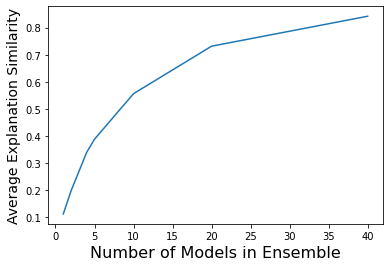

In [340]:
np.random.shuffle(avg_shap)
t, n, d = avg_shap.shape

# Compute cosine similarities

results = []
ensemble_model_num = [1, 2, 4, 5, 10, 20, 40]

for i in  ensemble_model_num:

    ensemble_shap = avg_shap.reshape(-1, i, n, d).mean(axis=1)

    cosine_sim_ensemble = cosine_similarity(ensemble_shap.reshape(ensemble_shap.shape[0], -1))

    trial_pairs_ensemble, cosine_values_ensemble = get_trial_pairs_and_cosine_values(cosine_sim_ensemble, 'E')
    results.append(np.mean(cosine_values_ensemble))
    
plt.plot(ensemble_model_num, results)

plt.ylabel("Average Explanation Similarity", size=14)
plt.xlabel("Number of Models in Ensemble", size=16)

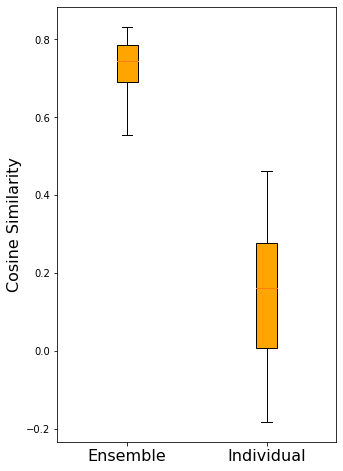

In [313]:


np.random.shuffle(avg_shap)
t, n, d = avg_shap.shape
ensemble_shap = avg_shap.reshape(-1, 20, n, d).mean(axis=1)

# Compute cosine similarities
cosine_sim_ensemble = cosine_similarity(ensemble_shap.reshape(ensemble_shap.shape[0], -1))
cosine_sim_individual = cosine_similarity(avg_shap[:10, :, :].reshape(10, -1))

trial_pairs_ensemble, cosine_values_ensemble = get_trial_pairs_and_cosine_values(cosine_sim_ensemble, 'E')
trial_pairs_individual, cosine_values_individual = get_trial_pairs_and_cosine_values(cosine_sim_individual, 'I')
# Generating random example data

# Create a figure and axis
fig, ax = plt.subplots(figsize=(5, 8))

# Ensemble data on left
x_ensemble = np.ones(len(trial_pairs_ensemble))
ax.boxplot(cosine_values_ensemble, positions=[1], patch_artist=True, boxprops=dict(facecolor="orange"), labels=["Ensemble"])

# Individual data on right, offset by the number of ensemble points
x_individual = np.ones(len(trial_pairs_individual)) + 1
ax.boxplot(cosine_values_individual, positions=[2], patch_artist=True, boxprops=dict(facecolor="orange"), labels=["Individual"])

# General settings
ax.set_xticklabels(['Ensemble', 'Individual'], fontsize=16)
plt.ylabel("Cosine Similarity", fontsize=16)
plt.show()

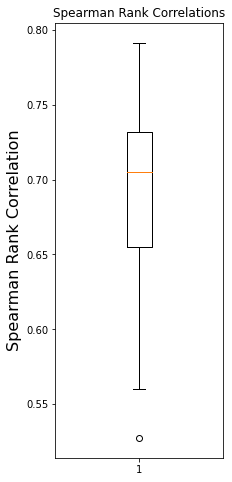

In [309]:
plt.figure(figsize=(3,8))
# plt.scatter( [i/1000 for i in range(len(rank_correlation))],rank_correlation)

plt.boxplot(rank_correlation)
plt.ylabel('Spearman Rank Correlation', size=16)
plt.title('Spearman Rank Correlations' )
plt.show()


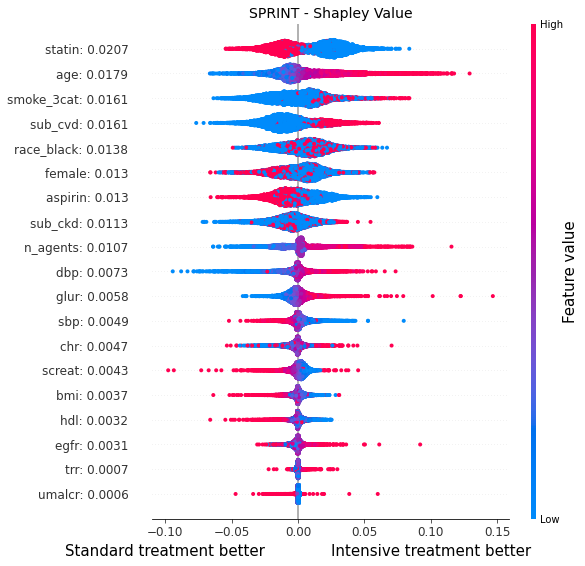

In [202]:
gender_index = data.get_feature_names().tolist().index('female')

avg_shap = pkl.load(open("results/sprint/shap_bootstrapped.pkl",'rb'))

plot_feature_values(
    avg_shap.mean(0),
    x, 
    data.get_feature_names()
)

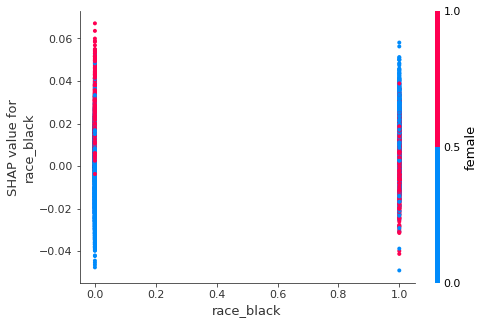

In [199]:
x_raw_con = data.get_unnorm_value(x)

x_raw = np.concatenate([x_raw_con, x[:, x_raw_con.shape[1]:]], axis=1)

shap.dependence_plot(
    "race_black", 
     avg_shap.mean(0), 
     x_raw, 
     feature_names=data.get_feature_names(),
     # interaction_index="smoke_3cat"
)

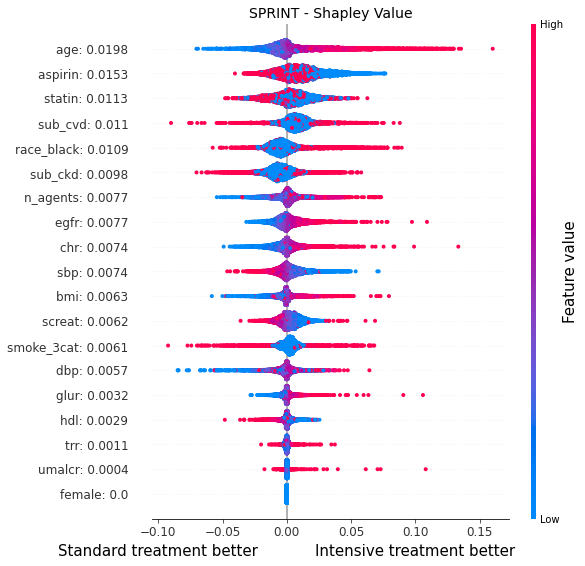

In [9]:
gender_index = data.get_feature_names().tolist().index('female')

avg_shap = pkl.load(open("results/sprint/female=0.0_shap.pkl",'rb'))

plot_feature_values(
    avg_shap.mean(0), 
    x[x[:, gender_index]== 0], 
    data.get_feature_names()
)

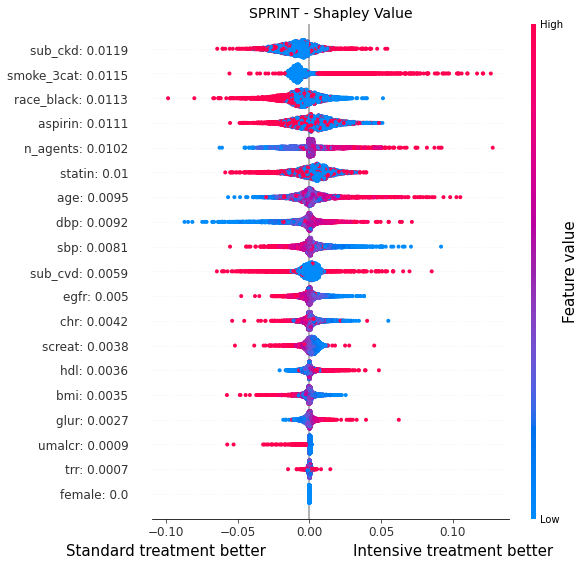

In [10]:
gender_index = data.get_feature_names().tolist().index('female')

avg_shap = pkl.load(open("results/sprint/female=1.0_shap.pkl",'rb'))

plot_feature_values(
    avg_shap.mean(0), 
    x[x[:, gender_index]== 1], 
    data.get_feature_names()
)

Shapley Value Sampling attribution: 100%|███| 2001/2001 [02:52<00:00, 11.59it/s]


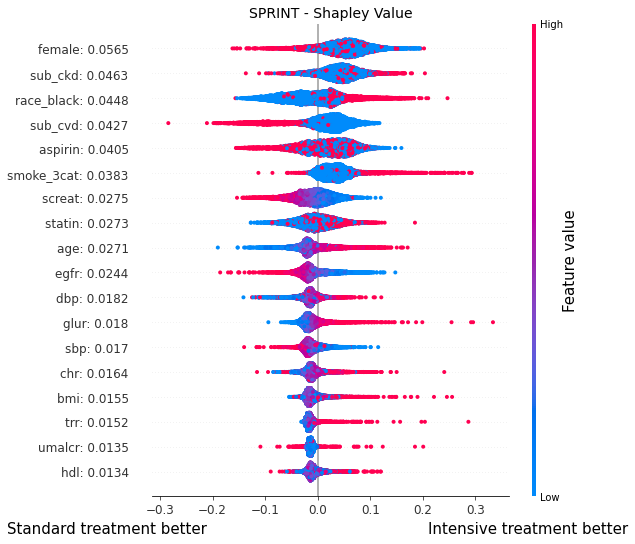

In [26]:
baseline = x.mean(0)

marginal_shapley_value_sampling_model = ShapleyValueSampling(model)

marginal_shapley_value = marginal_shapley_value_sampling_model.attribute(
                torch.tensor(x),
                n_samples=1000,
                baselines = torch.tensor(baseline.reshape(1,-1)),
                perturbations_per_eval = 10,
                show_progress=True
).detach().cpu().numpy()

plot_feature_values(marginal_shapley_value, x, data.get_feature_names())

Shapley Value Sampling attribution: 100%|███| 2001/2001 [02:53<00:00, 11.51it/s]


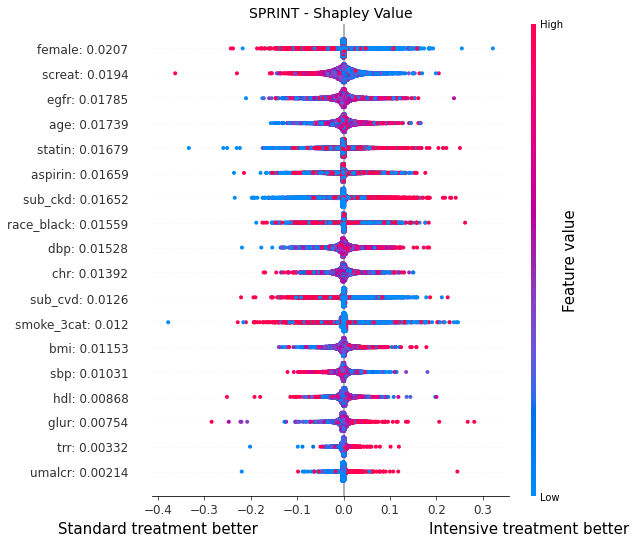

In [28]:
random_indices = np.random.choice(len(x), len(x), replace=True)

random_sampling_model = ShapleyValueSampling(model)

random_shapley_value = random_sampling_model.attribute(
                torch.tensor(x),
                n_samples=1000,
                baselines = torch.tensor(x[random_indices ,:]),
                perturbations_per_eval = 10,
                show_progress=True
).detach().cpu().numpy()

plot_feature_values(random_shapley_value, x, data.get_feature_names())

In [23]:
refe = torch.from_numpy(np.mean(x, axis=0).reshape(1,-1))

refe = x[np.random.choice(len(x), 2000, replace=False)]

explicand = x 

expl = shap.DeepExplainer(model, torch.from_numpy(refe))
attr = expl.shap_values(torch.from_numpy(explicand))

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


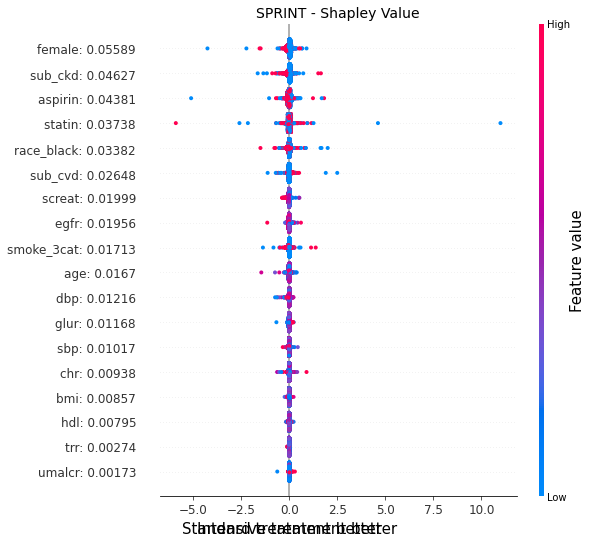

In [24]:
plot_feature_values(
    attr, 
    explicand, 
    data.get_feature_names()
)

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a fu

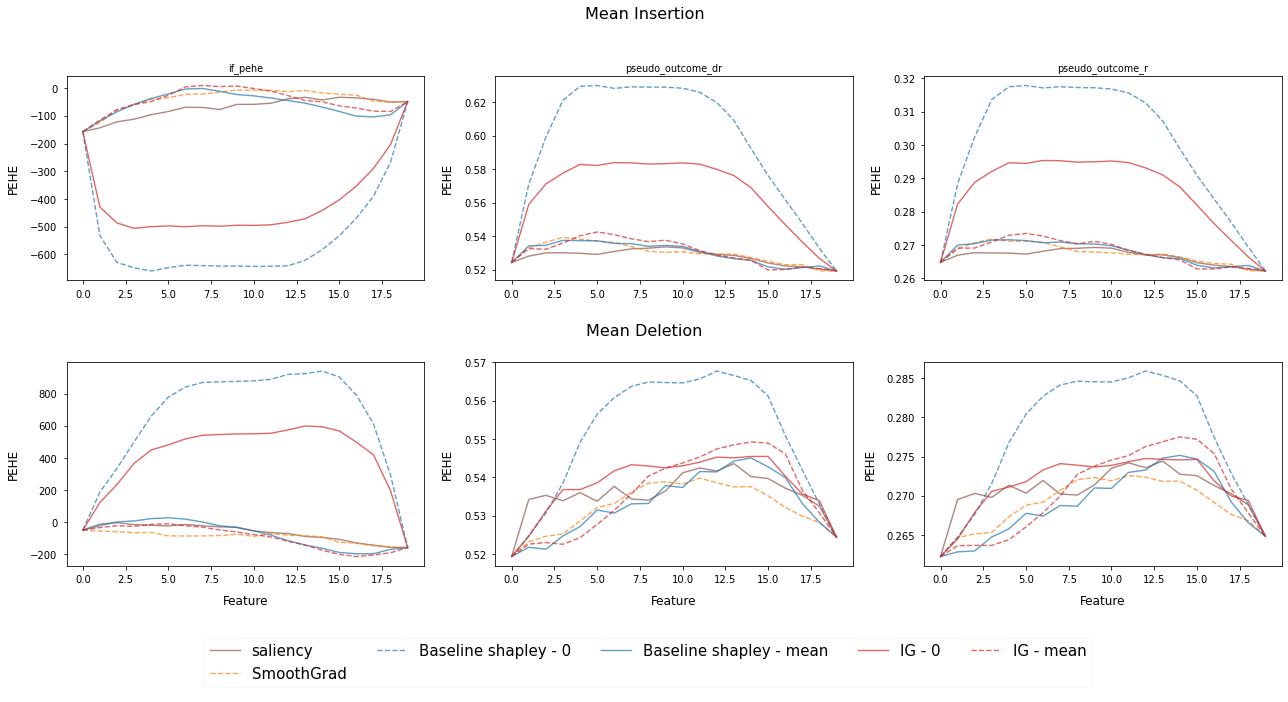

In [39]:
import pickle as pkl
import matplotlib.gridspec as gridspec

# Improved color palette
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

# Enhanced plot with better readability and visual appeal
plt.style.use('seaborn-paper')

learner = "XLearner"
shuffle = "False"

explainers = [
    "saliency",
    "smooth_grad",
    # "gradient_shap",
    # "lime",
    # "baseline_lime",
    "baseline_shapley_value_sampling",
    "marginal_shapley_value_sampling",
    "integrated_gradients",
    "baseline_integrated_gradients",
    # "kernel_shap"
    # "marginal_shap"
]

selection_types = [ 
    "if_pehe",
    "pseudo_outcome_dr", 
    "pseudo_outcome_r"
]



# Initialize dictionaries to store all results
insertion_results_all = {exp: {sel: [] for sel in selection_types} for exp in explainers}
deletion_results_all = {exp: {sel: [] for sel in selection_types} for exp in explainers}

train_score = {exp: [] for exp in explainers}
test_score = {exp: [] for exp in explainers}
mse = {exp: [] for exp in explainers}

test_score_full = []
train_score_full = []

random_score = []
random_mse = []
# Loop over the different files

seeds = [i for i in range(2)]

for i, file_num in enumerate(seeds):  # assuming there are 5 files, from 0 to 4
    
    # if file_num not in [1]:

    for selection_type in selection_types:
        file_path = f"results/sprint/insertion_deletion_shuffle_{shuffle}_{learner}_zero_baseline_True_seed_{file_num}.pkl"
        results = pkl.load(open(file_path,'rb'))

        for exp_index, exp in enumerate(explainers):
            insertion_results_all[exp][selection_type].append((results[exp_index][2][selection_type]))
            deletion_results_all[exp][selection_type].append((results[exp_index][3][selection_type]))
            
            train_score[exp].append(results[exp_index][4])
            test_score[exp].append(results[exp_index][5])
            mse[exp].append(results[exp_index][6])
            
            random_score.append(results[exp_index][8])
            random_mse.append(results[exp_index][9])
                        
            train_score_full.append(results[exp_index][10])
            test_score_full.append(results[exp_index][11])

# Create a grid for subplots
gs = gridspec.GridSpec(2, len(selection_types))

# Create figure
fig = plt.figure(figsize=(6 * len(selection_types), 10))

# To keep track of labels and lines for the legend
handles, labels = [], []

# Calculate and plot mean results
for i, selection_type in enumerate(selection_types):
    for exp in explainers:
        if exp == "baseline_shapley_value_sampling":
            label = "Baseline shapley - 0"
            color = colors[0]
            symbol = "--"
            
        elif exp == "marginal_shapley_value_sampling":
            label = "Baseline shapley - mean"
            color = colors[0]
            symbol = "-"
            
        elif exp == "smooth_grad":
            label = "SmoothGrad"
            color = colors[1]
            symbol = "--"
            
        elif exp == "lime":
            label = "Lime"
            color = colors[2]
            symbol = "--"

        elif exp == "baseline_lime":
            label = "Lime - mean"
            color = colors[2]
            symbol = "-"
            
        elif exp == "integrated_gradients":
            label = "IG - 0"
            color = colors[3]
            symbol = "-"

        elif exp == "baseline_integrated_gradients":
            label = "IG - mean"
            color = colors[3]
            symbol = "--"

        elif exp == "gradient_shap":
            label = "GradientShap"
            color = colors[4]
            symbol = "--"

        else:
            label = exp
            color = colors[5]
            symbol = "-"

        insertion_results_mean = np.mean(insertion_results_all[exp][selection_type], axis=0)
        deletion_results_mean = np.mean(deletion_results_all[exp][selection_type], axis=0)
        features_num = len(insertion_results_mean)

        
        insertion_results_std = np.std(insertion_results_all[exp][selection_type], axis=0)/np.sqrt(len(seeds))
        deletion_results_std = np.std(deletion_results_all[exp][selection_type], axis=0)/np.sqrt(len(seeds))

        # Insertion subplot
        ax1 = plt.subplot(gs[0, i])
        ax1.set_title(f"{selection_type}")
        ax1.set_ylabel('PEHE', fontsize=12, labelpad=10)
        ax1.tick_params(axis='both', which='major', labelsize=10)

        # Plot and store the line and label for legend
        line, = ax1.plot(range(features_num), insertion_results_mean, alpha=0.7, color = color, linestyle=symbol, markersize=3)
        # ax1.fill_between(range(features_num), insertion_results_mean - insertion_results_std, insertion_results_mean + insertion_results_std, alpha=0.2)

        # Deletion subplot
        ax2 = plt.subplot(gs[1, i])
        ax2.set_ylabel('PEHE', fontsize=12, labelpad=10)
        ax2.plot(range(features_num), deletion_results_mean,alpha=0.7,  color = color, linestyle = symbol, markersize=3)
        # ax2.fill_between(range(features_num), deletion_results_mean - deletion_results_std, deletion_results_mean + deletion_results_std, alpha=0.2)
        ax2.tick_params(axis='both', which='major', labelsize=10)

        # Add the line handle and label only if it doesn't exist
        if label not in labels:
            handles.append(line)
            labels.append(label)

# Set the x-label for only the bottom subplots
for i in range(len(selection_types)):
    ax = plt.subplot(gs[1, i])
    ax.set_xlabel('Feature', fontsize=12, labelpad=10)

# Set main titles for each row, outside of loops, and adjust positions
fig.text(0.5, 0.96, "Mean Insertion", ha='center', fontsize=16)
fig.text(0.5, 0.52, "Mean Deletion", ha='center', fontsize=16)

# Add a single legend for the entire figure with larger font size
# Move legend below the second row
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.1), fontsize=15, ncol=5)

# Adjust layout and add more space for the main titles
plt.tight_layout()
plt.subplots_adjust(top=0.88, hspace=0.4, bottom=0.2)
plt.show()

fig.savefig('ins_del_sprint.png', dpi=fig.dpi)

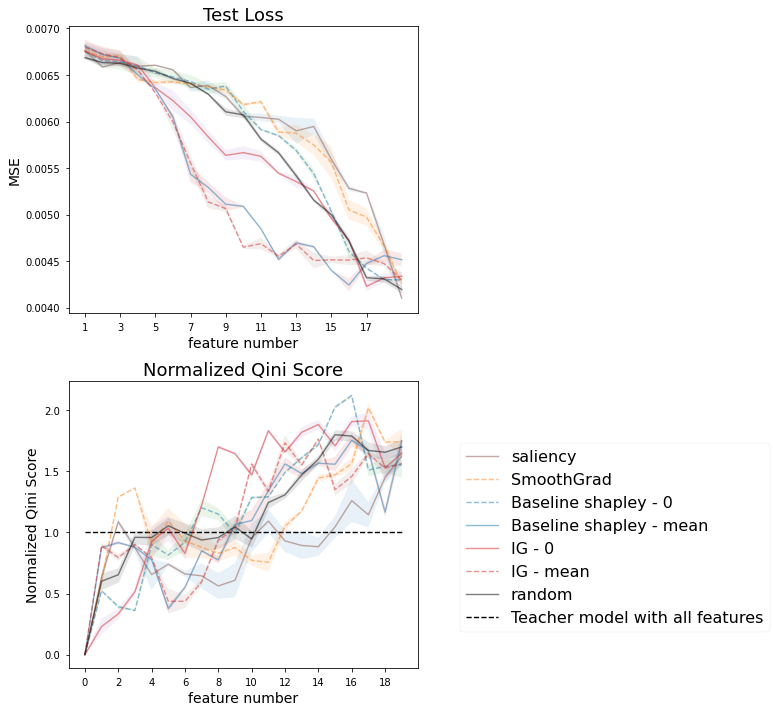

In [42]:
train_results = {exp: np.divide(np.array(result), np.mean(train_score_full)- 0.025).mean(axis=0) for exp, result in train_score.items()}
train_std  = {exp: np.divide(np.array(result), np.mean(train_score_full)- 0.025).std(axis=0) for exp, result in train_score.items()}

test_results  = {exp: np.array(result).mean(axis=0) for exp, result in test_score.items()}
test_std  = {exp: np.array(result).std(axis=0) for exp, result in test_score.items()}

mse_results  = {exp: np.array(result).mean(0) for exp, result in mse.items()}
mse_std  = {exp: np.array(result).std(0) for exp, result in mse.items()}


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,10))

# # Plot ATE results
# for k, v in ate_results.items():
#     feature_num = np.arange(v.shape[0] + 1)
#     ax1.plot(feature_num, np.insert(v, 0, 0), label=k)
#     ax1.fill_between(
#         feature_num,
#         np.insert(v, 0, 0) + np.insert(ate_std[k], 0, 0),
#         np.insert(v, 0, 0) - np.insert(ate_std[k], 0, 0),
#         alpha=0.1
#     )

# ax1.set_xticks(range(0, 16, 5))
# ax1.set_xlabel("feature number", size =14)
# ax1.set_ylabel("Subgroup Utility", size =14)
# ax1.set_title("Subgroup Identification (Subgroup Utility)",  size =17)

plt.style.use('seaborn-paper')

# Plot MSE results

for exp, v in mse_results.items():
    feature_num = np.arange(v.shape[0])
    feature_num = feature_num + 1
    
    if exp == "baseline_shapley_value_sampling":
        label = "Baseline shapley - 0"
        color = colors[0]
        symbol = "--"

    elif exp == "marginal_shapley_value_sampling":
        label = "Baseline shapley - mean"
        color = colors[0]
        symbol = "-"

    elif exp == "smooth_grad":
        label = "SmoothGrad"
        color = colors[1]
        symbol = "--"

    elif exp == "lime":
        label = "Lime - 0"
        color = colors[2]
        symbol = "--"

    elif exp == "baseline_lime":
        label = "Lime - mean"
        color = colors[2]
        symbol = "-"

    elif exp == "integrated_gradients":
        label = "IG - 0"
        color = colors[3]
        symbol = "-"

    elif exp == "baseline_integrated_gradients":
        label = "IG - mean"
        color = colors[3]
        symbol = "--"

    elif exp == "gradient_shap":
        label = "GradientShap"
        color = colors[4]
        symbol = "--"

    else:
        label = exp
        color = colors[5]
        symbol = "-"

    ax1.plot(feature_num, v, label=label, color = color, alpha=0.5, linestyle = symbol)
    
    ax1.fill_between(
        feature_num,
        v + mse_std[exp]/np.sqrt(len(mse_std)),
        v - mse_std[exp]/np.sqrt(len(mse_std)),
        alpha=0.1
    )
    
rand_std = np.std(random_mse, axis=0)/np.sqrt(20)
rand_mse = np.mean(random_mse, axis=0)

ax1.plot(feature_num, rand_mse, color = "black", label="random",alpha=0.5)
ax1.fill_between(
    feature_num,
    rand_mse + rand_std,
    rand_mse - rand_std,
    alpha=0.1,
    color = "black"
)
ax1.tick_params(axis='both', which='major', labelsize=10)
ax1.set_xticks(range(1,  v.shape[0], 2))
ax1.set_xlabel("feature number", size =14)
ax1.set_ylabel("MSE", size = 14)
ax1.set_title("Test Loss", size =18)


# Plot AUROC results
for exp, v in train_results.items():
    feature_num = np.arange(v.shape[0] + 1)
    
    if exp == "baseline_shapley_value_sampling":
        label = "Baseline shapley - 0"
        color = colors[0]
        symbol = "--"

    elif exp == "marginal_shapley_value_sampling":
        label = "Baseline shapley - mean"
        color = colors[0]
        symbol = "-"

    elif exp == "smooth_grad":
        label = "SmoothGrad"
        color = colors[1]
        symbol = "--"

    elif exp == "lime":
        label = "Lime - 0"
        color = colors[2]
        symbol = "--"

    elif exp == "baseline_lime":
        label = "Lime - mean"
        color = colors[2]
        symbol = "-"

    elif exp == "integrated_gradients":
        label = "IG - 0"
        color = colors[3]
        symbol = "-"

    elif exp == "baseline_integrated_gradients":
        label = "IG - mean"
        color = colors[3]
        symbol = "--"

    elif exp == "gradient_shap":
        label = "GradientShap"
        color = colors[4]
        symbol = "--"

    else:
        label = exp
        color = colors[5]
        symbol = "-"
        
    ax2.plot(feature_num, np.insert(v, 0, 0), color = color,alpha=0.5, linestyle= symbol, label=label)
    ax2.fill_between(
        feature_num,
        np.insert(v, 0, 0)+ np.insert(train_std[exp]/np.sqrt(20), 0, 0),
        np.insert(v, 0, 0)- np.insert(train_std[exp]/np.sqrt(20), 0, 0),
        alpha=0.1
    )

    
rand_std = np.insert(np.std(random_score/(np.mean(train_score_full) - 0.025), axis=0)/np.sqrt(20), 0,0)
rand_score = np.insert(np.mean(random_score, axis=0)/(np.mean(train_score_full) - 0.025), 0, 0)

ax2.plot(feature_num, rand_score, color = "black", label="random",alpha=0.5)
ax2.fill_between(
    feature_num,
    rand_score + rand_std,
    rand_score - rand_std,
    alpha=0.1,
    color = "black"
)

ax2.tick_params(axis='both', which='major', labelsize=10)

ax2.hlines(y=1., xmin=0, xmax=np.max(feature_num), color='black', linestyle='--', label="Teacher model with all features")
ax2.set_xticks(range(0,v.shape[0], 2))
ax2.set_xlabel("feature number", size =14)
ax2.set_ylabel("Normalized Qini Score",  size =14)
ax2.set_title("Normalized Qini Score",  size =18)

# Adjust legend location
handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right',prop={'size': 16}, bbox_to_anchor=(1.8, 0.1))

plt.tight_layout()
plt.show()

In [38]:
train_score_full

[[0.03765994301643147],
 [0.03765994301643147],
 [0.03765994301643147],
 [0.03765994301643147],
 [0.03765994301643147],
 [0.03765994301643147],
 [0.03765994301643147],
 [0.03765994301643147],
 [0.03765994301643147],
 [0.03765994301643147],
 [0.03765994301643147],
 [0.03765994301643147],
 [0.03765994301643147],
 [0.03765994301643147],
 [0.03765994301643147],
 [0.03765994301643147],
 [0.03765994301643147],
 [0.03765994301643147],
 [0.04423954296938394],
 [0.04423954296938394],
 [0.04423954296938394],
 [0.04423954296938394],
 [0.04423954296938394],
 [0.04423954296938394],
 [0.04423954296938394],
 [0.04423954296938394],
 [0.04423954296938394],
 [0.04423954296938394],
 [0.04423954296938394],
 [0.04423954296938394],
 [0.04423954296938394],
 [0.04423954296938394],
 [0.04423954296938394],
 [0.04423954296938394],
 [0.04423954296938394],
 [0.04423954296938394],
 array([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
      

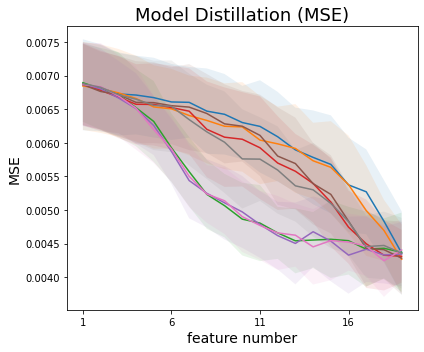

In [346]:
mse_results  = {exp: np.array(result).mean(0) for exp, result in mse.items()}
msec_std  = {exp: np.array(result).std(0) for exp, result in mse.items()}

plt.figure(figsize=(6,5))

# Plot MSE results
for k, v in mse_results.items():
    feature_num = np.arange(v.shape[0])
    feature_num = feature_num+1
    plt.plot(feature_num, v, label=k)
    
    plt.fill_between(
        feature_num,
        v + msec_std[k],
        v - msec_std[k],
        alpha=0.1
    )

plt.xticks(range(1, 18, 5))
plt.xlabel("feature number", size =14)
plt.ylabel("MSE", size = 14)
plt.title("Model Distillation (MSE)", size =18)

# plt.legend(loc='center right')

plt.tight_layout()
plt.show()

average tx effect 0.016690042487909056
average tx effect 0.018357205202962627


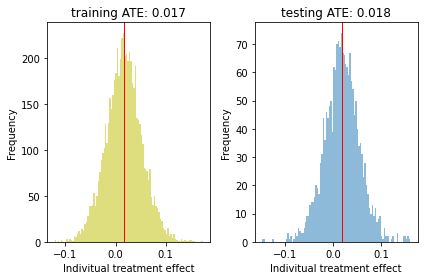

In [71]:
learner = "XLearner"
shuffle = "True"

results_train = pkl.load(open(f"results/sprint/train_shuffle_{shuffle}_{learner}.pkl", "rb"))
results_test = pkl.load(open(f"results/sprint/test_shuffle_{shuffle}_{learner}.pkl", "rb"))

print("average tx effect", np.mean(results_train))
print("average tx effect", np.mean(results_test))

plt.subplot(1,2,1)
plt.hist(np.mean(results_train, axis=0), bins=100 ,alpha= 0.5, color="y")
plt.axvline(x= np.mean(results_train), linewidth=1, color='r')

plt.title("training ATE: "+ str(np.round(np.mean(results_train), 3)))
plt.xlabel("Indivitual treatment effect")
plt.ylabel("Frequency")

plt.subplot(1,2,2)
plt.hist(np.mean(results_test, axis=0), bins=100, alpha = 0.5)
plt.axvline(x= np.mean(results_test), linewidth=1, color='r')

plt.title("testing ATE: "+ str(np.round(np.mean(results_test), 3)))
plt.xlabel("Indivitual treatment effect")
plt.ylabel("Frequency")
plt.tight_layout()